In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

E0000 00:00:1753155600.295943      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# --- Configuration ---
INPUT_DIR = Path("/kaggle/working/output_wav2vec_precomputed_5_class")
OUTPUT_DIR = Path("./output_dnn_5_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

# Model & Feature Params
MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

# Training Params
BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 150
LEARNING_RATE = 1e-4
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data_5_class.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data_5_class.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data_5_class.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_1d_cnn_5_class_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('✅ TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"⚠️ TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753155619.680128      10 service.cc:148] XLA service 0x591aeb45cbf0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753155619.680171      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753155619.680175      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753155619.680178      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753155619.680181      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753155619.680184      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753155619.680186      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753155619.680189      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753155619.680192      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
print("\n--- Loading all compressed features into RAM... ---")

# Load the compressed .npz files
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


--- Loading all compressed features into RAM... ---
All compressed data loaded successfully.
X_train shape: (28187, 150, 768)


In [11]:
print("\n--- Verifying final training set distribution after augmentation... ---")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


--- Verifying final training set distribution after augmentation... ---
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10038
WordRep          9346
dtype: int64


In [ ]:
print("\n--- Building tf.data pipeline... ---")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


--- Building tf.data pipeline... ---
Datasets created successfully.


In [ ]:
# The model must be defined and compiled within the strategy scope
with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)
    
        # We go directly to pooling after one block to keep the model simple
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
        # Classifier Head
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 150, 768)       │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_21     │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,077 (199.52 KB)

 Trainable params: 51,077 (199.52 KB)

 Non-trainable params: 0 (0.00 B)

LEARNING RATE: 0.0001
BATCH SIZE: 128


In [57]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/150


I0000 00:00:1753161846.832502      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14773870163157716127
I0000 00:00:1753161847.351951     894 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14765763022038670915), session_name()
I0000 00:00:1753161849.307917     894 tpu_compile_op_common.cc:245] Compilation of 14765763022038670915 with session name  took 1.955875235s and succeeded
I0000 00:00:1753161849.318574     894 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14765763022038670915), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14773870163157716127", property.function_library_fingerprint = 10215661977671928714, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap

220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2244 - auc: 0.5277 - loss: 0.7104 - precision: 0.4109 - recall: 0.2785

I0000 00:00:1753161856.815655     919 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5821491678189619603), session_name()
I0000 00:00:1753161858.777825     919 tpu_compile_op_common.cc:245] Compilation of 5821491678189619603 with session name  took 1.962124204s and succeeded
I0000 00:00:1753161858.786773     919 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5821491678189619603), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14773870163157716127", property.function_library_fingerprint = 10215661977671928714, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,150,768,;4,5,;", property.guaranteed_constants_size = 0, embedding_par

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2244 - auc: 0.5278 - loss: 0.7103 - precision: 0.4110 - recall: 0.2782

I0000 00:00:1753161874.426768      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11345665454720530303
I0000 00:00:1753161874.801383     954 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5048579580991222884), session_name()
I0000 00:00:1753161875.601453     954 tpu_compile_op_common.cc:245] Compilation of 5048579580991222884 with session name  took 799.966272ms and succeeded
I0000 00:00:1753161875.606900     954 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5048579580991222884), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_11345665454720530303", property.function_library_fingerprint = 12386149813184055966, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().


Epoch 1: val_auc improved from -inf to 0.62338, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.2244 - auc: 0.5279 - loss: 0.7101 - precision: 0.4111 - recall: 0.2779 - val_accuracy: 0.1909 - val_auc: 0.6234 - val_loss: 0.6619 - val_precision: 0.4587 - val_recall: 0.0894
Epoch 2/150
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2526 - auc: 0.5874 - loss: 0.6451 - precision: 0.4976 - recall: 0.1933
Epoch 2: val_auc improved from 0.62338 to 0.64583, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 104ms/step - accuracy: 0.2526 - auc: 0.5876 - loss: 0.6451 - precision: 0.4978 - recall: 0.1933 - val_accuracy: 0.1782 - val_auc: 0.6458 - val_loss: 0.6552 - val_precision: 0.5427 - val_recall: 0.1433
Epoch 3/150
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2748 - auc: 0.6126 - loss: 0.6345 - precision: 0.5335 - recall: 0.214


--- Evaluating Model on the Test Set ---


I0000 00:00:1753159804.126875      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2327550081989577742
E0000 00:00:1753159804.133548      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/dense_10_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753159804.161546     974 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5262385129793627562), session_name()
I0000 00:00:1753159804.250423     974 tpu_compile_op_common.cc:245] Compilation of 5262385129793627562 with session name  took 88.829114ms and succeeded
I0000 00:00:1753159804.251156     974 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5262385129793627562), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2327550081989577742", property.function_library_fingerprint = 13053564561778365434, property.mlir_module_fingerpr

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

I0000 00:00:1753159809.085291      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2989492059375095073
I0000 00:00:1753159809.241195     885 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(544196751946658986), session_name()
I0000 00:00:1753159809.333031     885 tpu_compile_op_common.cc:245] Compilation of 544196751946658986 with session name  took 91.787796ms and succeeded
I0000 00:00:1753159809.333566     885 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(544196751946658986), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2989492059375095073", property.function_library_fingerprint = 5793921224590184853, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wr

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.66      0.35      0.46      2613
       Block       0.66      0.27      0.38      3501
    SoundRep       0.59      0.38      0.46      1891
     WordRep       0.47      0.45      0.46      1742
Interjection       0.81      0.58      0.68      3344

   micro avg       0.65      0.40      0.50     13091
   macro avg       0.64      0.41      0.49     13091
weighted avg       0.66      0.40      0.49     13091
 samples avg       0.53      0.41      0.44     13091


--- Generating plots for model training history... ---


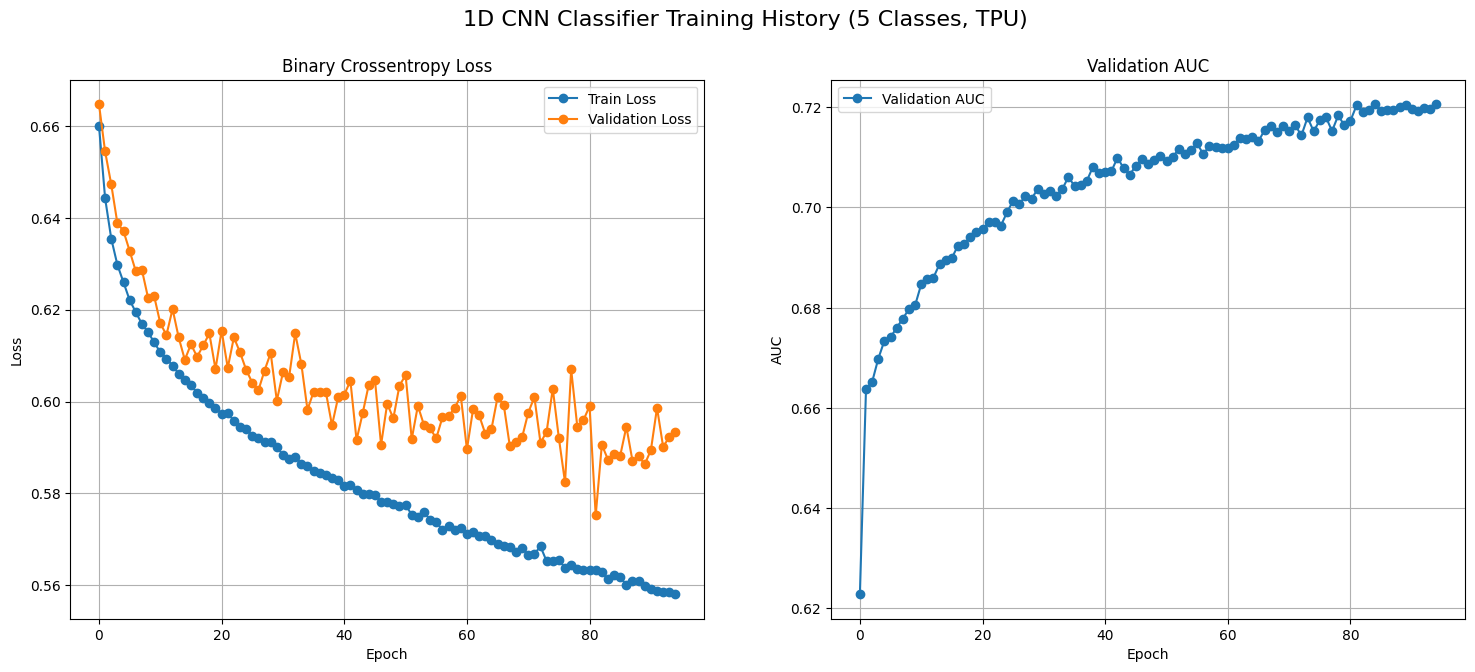

In [ ]:
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)    # should be DNN
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()



--- Evaluating Model on the Test Set ---


I0000 00:00:1753165740.512762      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6379227663409145939
E0000 00:00:1753165740.520114      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_21_1/dense_45_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753165740.550598     943 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16243153197867380390), session_name()
I0000 00:00:1753165740.756871     943 tpu_compile_op_common.cc:245] Compilation of 16243153197867380390 with session name  took 206.149165ms and succeeded
I0000 00:00:1753165740.758047     943 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16243153197867380390), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_6379227663409145939", property.function_library_fingerprint = 12017106553036970418, property.mlir_module_fin

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

I0000 00:00:1753165745.913348      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10426633756992959579
I0000 00:00:1753165746.019525     943 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10329237056916257750), session_name()
I0000 00:00:1753165746.140837     943 tpu_compile_op_common.cc:245] Compilation of 10329237056916257750 with session name  took 121.277264ms and succeeded
I0000 00:00:1753165746.141586     943 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10329237056916257750), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10426633756992959579", property.function_library_fingerprint = 13640620896190096257, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, t

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.68      0.34      0.45      2613
       Block       0.68      0.19      0.30      3501
    SoundRep       0.67      0.28      0.40      1891
     WordRep       0.51      0.40      0.45      1742
Interjection       0.82      0.54      0.65      3344

   micro avg       0.69      0.35      0.47     13091
   macro avg       0.67      0.35      0.45     13091
weighted avg       0.69      0.35      0.45     13091
 samples avg       0.49      0.36      0.39     13091


--- Generating plots for model training history... ---


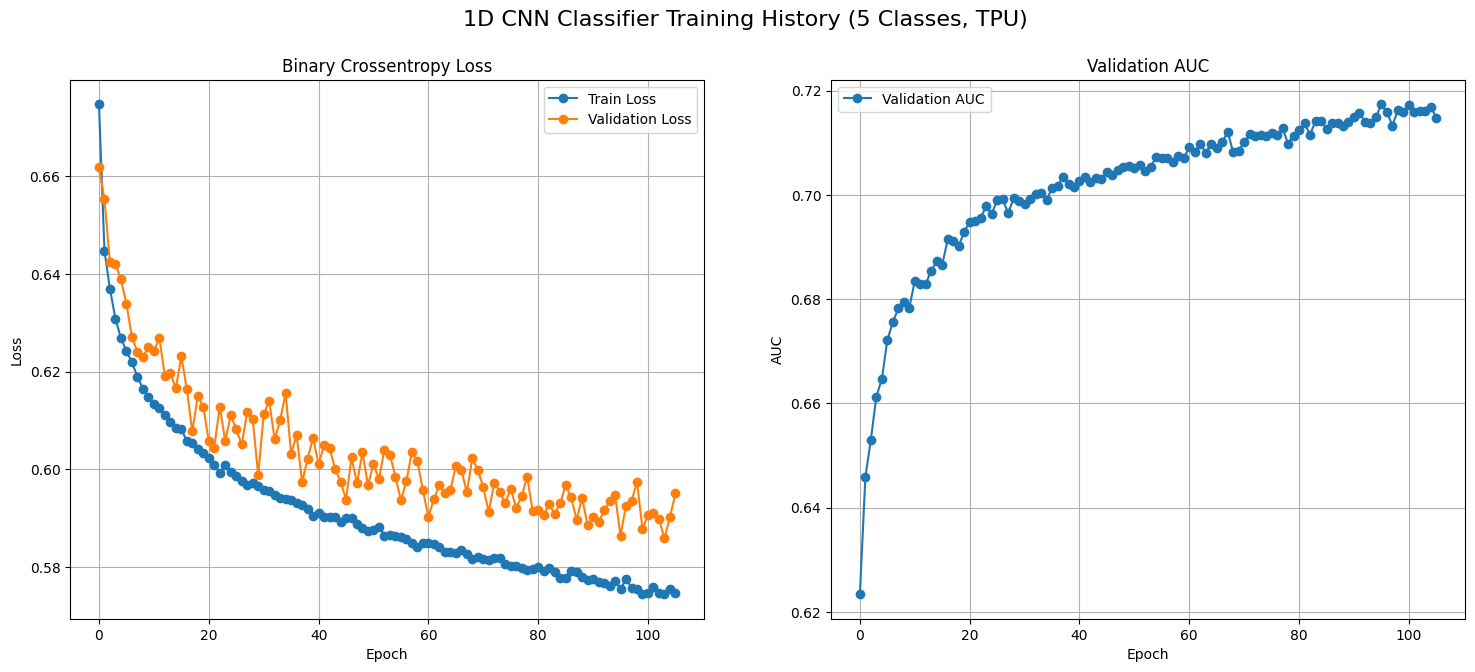

In [ ]:
# Decreased LR to 1e-6
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)   # should be DNN
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()
